In [25]:
from keras.layers import Conv2D, UpSampling2D, Input, Lambda, MaxPool2D, Reshape
from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

In [26]:
# HYPERPARAMETERS

TRAIN_EPOCHS: int = 10
IMAGE_SHAPE: tuple = (720, 1280)

In [27]:
# Define encoder
encoder_input_shape = (IMAGE_SHAPE + (3,)) # Add color dim to input shape
encoder: Model = VGG16(include_top=False, weights='imagenet', input_shape=encoder_input_shape)

# Freeze the pretrained layers
for layer in encoder.layers:
    layer.trainable = False

# Access the output shape of the encoder
encoder_output_shape = encoder.output_shape[1:] # Drop batch size element
print('VGG16-based encoder output shape: ' + str(encoder_output_shape))

# Display summary of encoder model
encoder.summary()

VGG16 encoder output shape: (22, 40, 512)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 720, 1280, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 720, 1280, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 720, 1280, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 360, 640, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 360, 640, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 360, 640, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 180, 320, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 180, 320, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 180, 320, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 180, 320, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 90, 160, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 90, 160, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 90, 160, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 90, 160, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 45, 80, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 22, 40, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Define decoder

decoder = Sequential(
    [
        Conv2D(256, (3,3), activation='relu', padding='same', input_shape=encoder_output_shape),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(2, (3, 3), activation='tanh', padding='same'),
        UpSampling2D((2, 2)),
        Lambda(lambda x: tf.image.resize(x, IMAGE_SHAPE, method=tf.image.ResizeMethod.BILINEAR))
    ],
    name='Colorization Decoder'
)

# Access the output shape of the decoder
decoder_output_shape = decoder.output_shape[1:] # Drop batch size element
print('Decoder output shape: ' + str(decoder_output_shape))

decoder.summary()

Decoder output shape: (720, 1280, 2)


Model: "Colorization Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 22, 40, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 22, 40, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_50 (UpSampling2D) │ (None, 44, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 44, 80, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_51 (UpSampling2D) │ (None, 88, 160, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 88, 160, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_52 (UpSampling2D) │ (None, 176, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 176, 320, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_53 (UpSampling2D) │ (None, 352, 640, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 352, 640, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_54 (UpSampling2D) │ (None, 704, 1280, 2)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 720, 1280, 2)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
colorizer_model = Sequential(
    [
        encoder,
        decoder
    ]
)
colorizer_model.compile()
colorizer_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Colorization Decoder            │ ?                      │     1,572,114 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,286,802 (62.13 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
#  Generate data

import create_video as cc

data_path: str = './videos/'
frames: list = cc.process_video_frames(data_path=data_path)


Processing barbie.mp4...
Finished processing barbie.mp4. Exiting ...


<function list.__sizeof__()>

In [53]:
import matplotlib.pyplot as plt

def display_img(img, cmap=None): 
# Load and display an image
    plt.imshow(img, cmap=cmap) ## add param for grayscale: cmap='gray'  ##
    plt.axis('off')  # Hide the axis
    plt.show()

# train_l[0]

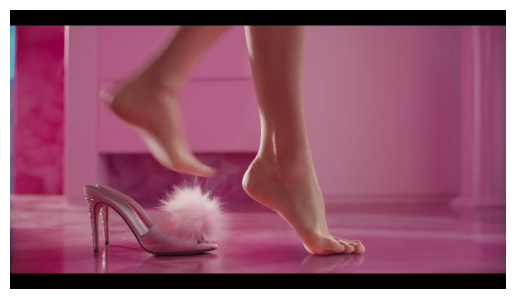

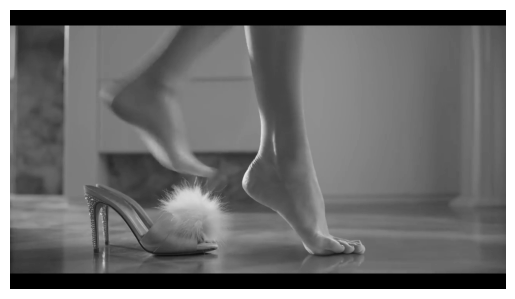

In [55]:

# frames.__sizeof__()

# Pre-Processing
rgb_img, gray_img = frames[100]
display_img(rgb_img)
display_img(gray_img, cmap='gray')


In [ ]:
# Lets get to training these SOBs

